In [1]:
try:
    import pyopencl as cl
except ImportError as e:
    msg =("pyopencl is not installed.\n"
          "The preferred way to install this is through conda, i.e \n"
          "conda install pyopencl -y")
    raise ImportError(msg) from e


In [2]:
import numpy as np
import numpy.linalg as la

mf = cl.mem_flags

In [3]:
import pyopencl.array

Create a context - select the platform and device you want to use for the computation

In [4]:
ctx = cl.create_some_context(interactive=True)

Choose platform:
[0] <pyopencl.Platform 'Apple' at 0x7fc363736ce0>
Choice [0]:0
Choose device(s):
[0] <pyopencl.Device 'Intel(R) Core(TM) i9-8950HK CPU @ 2.90GHz' on 'Apple' at 0x7fc363779d90>
[1] <pyopencl.Device 'Intel(R) UHD Graphics 630' on 'Apple' at 0x7fc36377cc30>
[2] <pyopencl.Device 'AMD Radeon Pro 560X Compute Engine' on 'Apple' at 0x7fc36377cc50>
Choice, comma-separated [0]:2
Set the environment variable PYOPENCL_CTX='0:2' to avoid being asked again.


Create Command queue for the context

In [5]:
queue = cl.CommandQueue(ctx)

Before running the remainder of this notebook, ensure that `make` has been run so that the `model.cl` and `model.py` files exist.

In [6]:
!make clean
!make

rm -f tentusscher_panfilov_2006_M_cell.cl
rm -f tentusscher_panfilov_2006_M_cell.py
rm -f -r __pycache__
gotran2opencl tentusscher_panfilov_2006_M_cell.ode --solvers.explicit_euler.generate=1 --solvers.explicit_euler.function_name=FE --solvers.generalized_rush_larsen.generate=1 --solvers.generalized_rush_larsen.function_name=GRL1 --code.body.use_enum=1 --output=tentusscher_panfilov_2006_M_cell.cl
Note: The OpenCL support in gotran is a work in progress. The CUDA generator is recommended for NVIDIA GPUs.
Loaded ODE model 'tentusscher_panfilov_2006_M_cell' with:
     Num full states: 19
      Num parameters: 53

Generating OpenCL code for the tentusscher_panfilov_2006_M_cell ode...  done.
gotran2py tentusscher_panfilov_2006_M_cell.ode
Loaded ODE model 'tentusscher_panfilov_2006_M_cell' with:
     Num full states: 19
      Num parameters: 53

Generating Python code for the tentusscher_panfilov_2006_M_cell ode...  done.


The OpenCL kernel is written to the file `tentusscher_panfilov_2006_M_cell.cl`. We load this kernel and build it using `pyopencl`

In [7]:
prg_filename = 'tentusscher_panfilov_2006_M_cell.cl'

with open(prg_filename, 'r') as f:
    prg_str = f.read()
    
prg = cl.Program(ctx, prg_str).build()

We import the same model using the python API in order to collect the parameter and state values

In [8]:
import tentusscher_panfilov_2006_M_cell as TT06

In [9]:
parameters = TT06.init_parameter_values()
default_initial_state_values = TT06.init_state_values()
num_states = default_initial_state_values.shape[0]

The index for the membrane potential

In [10]:
V_index = TT06.state_indices("V")

We solve this using `num_cells` cells

In [11]:
num_cells = 4
states = np.zeros((num_states, num_cells), dtype=np.float64)

We copy the arrays for the states and parameters to the device (i.e the GPU)

In [12]:
d_states = cl.array.to_device(queue, states)
d_parameters = cl.array.to_device(queue, parameters)

In [13]:
WORK_GROUP_SIZE = None

In [14]:
%%time
t_end = 500
dt = np.float64(1E-2)
num_timesteps = round(t_end / float(dt))


t_values = np.zeros(num_timesteps, dtype=np.float64)
V_trace = np.zeros((num_timesteps, num_cells), dtype=np.float64)

t = np.float64(0.0)

prg.init_state_values(
    queue, (num_cells,), None,#(WORK_GROUP_SIZE,), 
    d_states.data, np.uint32(num_cells)
)

# This loop should ideally be written in openCL
for i in range(num_timesteps):
    prg.GRL1(
        queue, 
        (num_cells,), 
        None,#(WORK_GROUP_SIZE,), 
        d_states.data, 
        t, 
        dt, 
        d_parameters.data, 
        np.uint32(num_cells)
    )
    t += dt
    
    t_values[i] = t
    V_trace[i] = d_states[V_index].get()

CPU times: user 12 s, sys: 7.21 s, total: 19.2 s
Wall time: 32.8 s


In [15]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

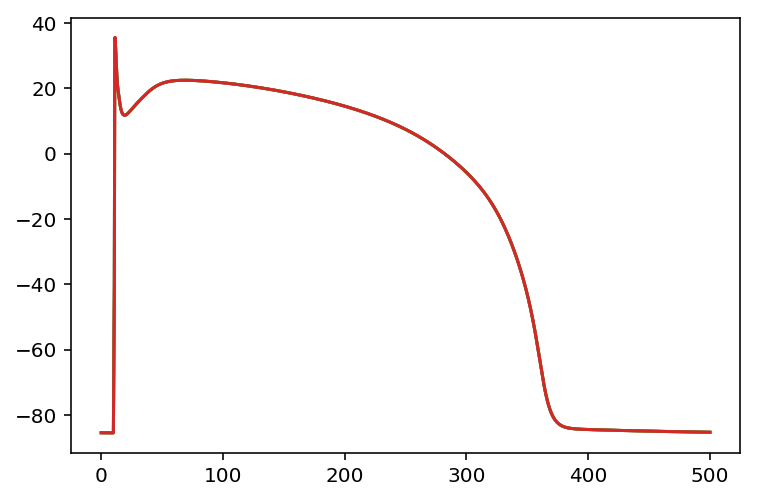

In [16]:
plt.plot(t_values, V_trace)
plt.show()

In [17]:
prg.kernel_names

'init_state_values;rhs;FE;GRL1;get_field_states;set_field_states'